In [1]:
from __future__ import print_function
from __future__ import division
import os
import pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import scipy.io.wavfile
from python_speech_features import mfcc
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import bisect

%run ../antonissameer/dba.py
%run ../antonissameer/utils.py

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [4]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Instance = namedtuple('Instance', ['uttr', 'start', 'end'])

In [5]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"), encoding='utf-8')

### Find words spoken across speakers, and within speakers

Find words longer than *threshold* ms in duration

In [6]:
dur_thresh = 40 # 400 ms
word_type = "es_cnt"

def get_word_details(dur_thresh, word_type):
    word_list = [(a.word, fid, sid, i) for fid in align_dict 
                for sid in align_dict[fid] 
                for i, a in enumerate(align_dict[fid][sid][word_type]) 
                if (a.end-a.start) > dur_thresh]

    word_details = {}
    for w, f, s, i in word_list:
        if w not in word_details:
            word_details[w] = {"calls":[f], "uttrs":[s], "ixs":[i]}
        else:
            word_details[w]["calls"].append(f)
            word_details[w]["uttrs"].append(s)
            word_details[w]["ixs"].append(i)
    
    for w in word_details:
        word_details[w]["word_count"] = len(word_details[w]["ixs"])
        word_details[w]["call_count"] = len(set(word_details[w]["calls"]))
        word_details[w]["uttr_count"] = len(set(word_details[w]["uttrs"]))
        
    print("duration filter: {0:d} ms".format(dur_thresh*10))
    print("{0:10s} --- {1:5d}".format("total words", len(word_details)))
    
    return word_details

In [7]:
def print_index_details(word_details, w, i):
    align_ix = word_details[w]["ixs"][i]
    call_id = word_details[w]["calls"][i]
    seg_id = word_details[w]["uttrs"][i]
    loc = "{0:d} - {1:d} ms".format(align_dict[call_id][seg_id][word_type][align_ix].start, 
                    align_dict[call_id][seg_id][word_type][align_ix].end) 
    print("""details for: {0:10s} 
             in uttr: {1:7s} 
             at time: {2:10s}""".format(w, word_details[w]["uttrs"][i], loc))

In [8]:
def print_word_details(word_details, w):
    print("details for: {0:10s}".format(w))
    print("{0:10s} | {1:5d}".format("word count", word_details[w]["word_count"]))
    print("{0:10s} | {1:5d}".format("call count", word_details[w]["call_count"]))
    print("{0:10s} | {1:5d}".format("uttr count", word_details[w]["uttr_count"]))

In [279]:
word_details = get_word_details(dur_thresh, word_type)

duration filter: 400 ms
total words ---  8224


In [280]:
# display the most common words
most_common = sorted([(w, word_details[w]["word_count"]) for w in word_details], 
                           reverse=True, key=lambda t:t[1])[:5]
print("{0:20s} --- {1:10s}".format("word", "count"))
print("".join(["{0:20s} --- {1:5d}\n".format(w, f) for w, f in most_common]))

word                 --- count     
MMM                  ---   504
<LAUGH>              ---   499
ENTONCES             ---   450
CLARO                ---   363
AH                   ---   298



In [281]:
most_common_by_calls = sorted(
    [(w, word_details[w]["word_count"], word_details[w]["call_count"]) 
     for w in word_details], reverse=True, key=lambda t:t[2])
print("{0:10s} | {1:5} | {2:5} ".format("word", "count", "calls"))
print("".join(["{0:10s} | {1:5d} | {2:5d} \n".format(w,c,f) 
              for w, c, f in most_common_by_calls[:10]]))

word       | count | calls 
ENTONCES   |   450 |    91 
MMM        |   504 |    88 
<LAUGH>    |   499 |    79 
AH         |   298 |    79 
BUENO      |   291 |    78 
BIEN       |   247 |    77 
CLARO      |   363 |    71 
TELéFONO   |    94 |    55 
EH         |   163 |    54 
DESPUéS    |    70 |    50 



In [282]:
es_word = 'TELéFONO'
uttr_wavs_path_string = "../uttr_fa_vad_wavs/uttr_wavs/{0:s}.wav"

In [283]:
print_word_details(word_details, es_word)

details for: TELéFONO  
word count |    94
call count |    55
uttr count |    88


In [284]:
def get_align_tuple(word_details, w, ix):
    return (word_details[w]["calls"][ix], 
               word_details[w]["uttrs"][ix],
               word_details[w]["ixs"][ix])

In [285]:
def get_segment_wav(sid, start_10ms, end_10ms):
    sr1, y1 = scipy.io.wavfile.read(uttr_wavs_path_string.format(sid))
    start = start_10ms * int(sr1 / 100)
    end = end_10ms * int(sr1 / 100)
    return sr1, y1[start:end]

In [286]:
def _get_segment_mfcc(sid, start_10ms, end_10ms):
    sr1, y1 = get_segment_wav(sid, start_10ms, end_10ms)
    mfcc_segment = mfcc(y1, sr1)
    mfcc_segment = (mfcc_segment - np.mean(mfcc_segment)) / np.std(mfcc_segment)
    return mfcc_segment

In [287]:
def get_start_end_10ms(f,s,ind):
    return align_dict[f][s]["es_cnt"][ind].start, align_dict[f][s]["es_cnt"][ind].end

In [288]:
def compute_dtw(w_1, w_2):
    f1, s1, ind1 = w_1
    start_i, end_i = get_start_end_10ms(f1, s1, ind1)
    i_mfcc = _get_segment_mfcc(s1, start_i, end_i)
    
    f2, s2, ind2 = w_2
    start_j, end_j = get_start_end_10ms(f2, s2, ind2)
    j_mfcc = _get_segment_mfcc(s2, start_j, end_j)
    
    # compute dtw
    pair_cost, _ = dtw(i_mfcc, j_mfcc, doNorm=True)
    return pair_cost

In [289]:
def compute_align_pairwise_dtw(loc_tuples):
    d = len(loc_tuples)
    cost = np.zeros((d, d))
    
    with tqdm(total=d*d) as pbar:
        for i in range(d):
#             f1, s1, ind1 = loc_tuples[i]
#             start_i, end_i = get_start_end_10ms(f1, s1, ind1)
#             i_mfcc = _get_segment_mfcc(s1, start_i, end_i)
            cost[i,i] = 1
            pbar.update(1)
            for j in range(i+1, d):
                it = i * d + (j + 1)
#                 f2, s2, ind2 = loc_tuples[j]
#                 start_j, end_j = get_start_end_10ms(f2, s2, ind2)
#                 j_mfcc = _get_segment_mfcc(s2, start_j, end_j)
                # compute dtw
#                 pair_cost, _ = dtw(i_mfcc, j_mfcc, doNorm=True)
                pair_cost = compute_dtw(loc_tuples[i], loc_tuples[j])
                cost[i,j] = pair_cost
                cost[j,i] = 1.0
                pbar.set_description("it: {0:d}".format(it))
                pbar.update(2)
    return cost
    

In [290]:
def get_calls_for_word(words_details, word):
    word_segments = {}
    for w, f, s, i in words_details:
        if w == word:
            if f not in word_segments:
                word_segments[f] = 1
            else:
                word_segments[f] += 1
    print("done")
    return word_segments

In [291]:
def get_segment_mfcc(words_details, w, ix):
    call, uttr, index = get_align_tuple(words_details, w, ix)
    start_i, end_i = get_start_end_10ms(call, uttr, index)
    return _get_segment_mfcc(uttr, start_i, end_i)

In [292]:
def play_uttr_seg(uttr, start_i, end_i):
    sr, y = get_segment_wav(uttr, start_i, end_i)
    display(Audio(y, rate=sr))

In [293]:
def play_align_seg(words_details, w, ix):
    call = words_details[w]["calls"][ix]
    uttr = words_details[w]["uttrs"][ix]
    index = words_details[w]["ixs"][ix]
    start_i, end_i = get_start_end_10ms(call, uttr, index)
    time_str = "{0:d} - {1:d} ms".format(start_i, end_i) 
    print("{0:10s} | {1:7s} | {2:8s}".format(es_word, 
                                             word_details[es_word]["uttrs"][ix],
                                             time_str))
    play_uttr_seg(uttr, start_i, end_i)

In [294]:
def get_dba_for_word_samples(word_details, w, ixs):
    word_mfccs = []
    for ix in ixs:
        word_mfccs.append(get_segment_mfcc(word_details, w, ix))
    word_dba = dba(s=word_mfccs)
    return word_dba

In [295]:
def print_align(uttr, key='es'):
    words = " ".join([w.word for w in align_dict[uttr.split('.')[0]][uttr][key]])
    print("{0:>15s} | {1:>40s}".format(key + " words", words.lower()))

In [296]:
def find_align_words_for_node(uttr, start, end, key='es'):
    align_words_list = align_dict[uttr.split('.')[0]][uttr][key]
    words, start_times, end_times = zip(*(align_words_list))
    start_i = bisect.bisect(end_times, start)
    # end index will be 1 beyond the actual end
    end_i = bisect.bisect(start_times, end) 
    print("{0:>15s} | {1:>20s}, {2:d} ms".format(key + " alignment", 
                                                  " ".join(words[start_i:end_i]),
                                                 (end_times[end_i-1]-start_times[start_i])*10))
    return words[start_i:end_i]

In [297]:
# Play few audio segments:
for i in range(3):
    play_align_seg(word_details, es_word, i)

TELéFONO   | 021.077 | 256 - 309 ms


TELéFONO   | 021.087 | 555 - 608 ms


TELéFONO   | 021.087 | 732 - 827 ms


In [28]:

word_tuples = [(word_details[es_word]["calls"][i], 
                word_details[es_word]["uttrs"][i], 
                word_details[es_word]["ixs"][i]) 
               for i in range(word_details[es_word]["word_count"])]

In [301]:
cost_es = compute_align_pairwise_dtw(word_tuples[:10])

it: 90: 100%|██████████| 100/100 [00:00<00:00, 193.21it/s]


### Get top 10 matches

argpartition reorders indices by moving smaller elements in front of the *10th* largest value, and larger elements after it

In [298]:
def print_top_k_matches(arr2D, word_details, es_word, k=5, reverse=False):
    if reverse:
        arr2D[np.tril_indices(arr2D.shape[0])] = 0
        ind = np.unravel_index(np.argpartition(arr2D, -k, axis=None)[-k:], arr2D.shape)
    else:
        arr2D[np.tril_indices(arr2D.shape[0])] = 1
        ind = np.unravel_index(np.argpartition(arr2D, k, axis=None)[:k], arr2D.shape)
    for i, (x,y) in enumerate(zip(ind[0], ind[1])):
        print(x,y)
        x_t = get_align_tuple(word_details, es_word, x)
        y_t = get_align_tuple(word_details, es_word, y)
        print("--------------------\n Pair - {0:2d}".format(i))
        play_align_seg(word_details, es_word, x)
        play_align_seg(word_details, es_word, y)
        print("{0:<25s} | {1:10.3f}".format("dtw for seg 1 vs seg2", 1-cost[x,y]))
        #print("--------------------\n computing dba")
        mfcc_x = get_segment_mfcc(word_details, es_word, x)
        mfcc_y = get_segment_mfcc(word_details, es_word, y)
        dba_repr = dba([get_segment_mfcc(word_details, es_word, x),
                       get_segment_mfcc(word_details, es_word, y)])
        # compute dtw
        pair_cost_x, _ = dtw(mfcc_x, dba_repr, doNorm=True)
        pair_cost_y, _ = dtw(mfcc_y, dba_repr, doNorm=True)
        print("{0:<25s} | {1:10.3f}".format("dtw for seg 1 vs DBA", 1-pair_cost_x))
        print("{0:<25s} | {1:10.3f}".format("dtw for seg 2 vs DBA", 1-pair_cost_y))
        #print("{0:<25s} | {1:10.3f}".format("dtw for seg 1 vs 2", dtw(mfcc_x, mfcc_y, doNorm=True)[0]))
        
        '''
        print(compute_dtw(get_align_tuple(word_details, es_word, x), 
                          get_align_tuple(word_details, es_word, y)))
        '''
    return ind
    

In [302]:
print("Best matches")
ind = print_top_k_matches(cost_es, word_details, es_word, 1, reverse=False)
print("\n\n--------------------")
print("Worst matches")
ind = print_top_k_matches(cost_es, word_details, es_word, 1, reverse=True)

Best matches
4 5
--------------------
 Pair -  0
TELéFONO   | 049.124 | 386 - 438 ms


TELéFONO   | 049.131 | 152 - 210 ms


dtw for seg 1 vs seg2     |      0.708
dtw for seg 1 vs DBA      |      0.996
dtw for seg 2 vs DBA      |      0.876


--------------------
Worst matches
8 9
--------------------
 Pair -  0
TELéFONO   | 049.147 | 245 - 302 ms


TELéFONO   | 115.017 | 204 - 257 ms


dtw for seg 1 vs seg2     |      0.649
dtw for seg 1 vs DBA      |      0.617
dtw for seg 2 vs DBA      |      0.995


[[ 1.     0.424  0.291 ...,  0.31   0.421  0.323]
 [ 1.     1.     0.33  ...,  0.346  0.391  0.281]
 [ 1.     1.     1.    ...,  0.308  0.481  0.233]
 ..., 
 [ 1.     1.     1.    ...,  1.     0.415  0.291]
 [ 1.     1.     1.    ...,  1.     1.     0.399]
 [ 1.     1.     1.    ...,  1.     1.     1.   ]]


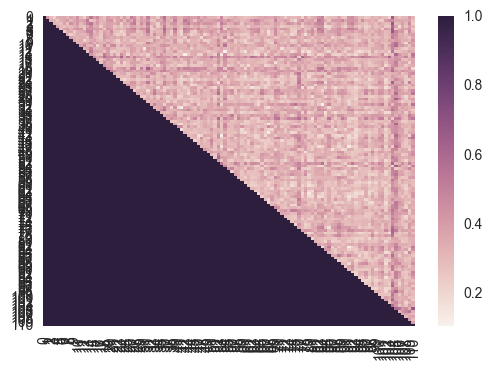

In [303]:
# plt.imshow(cost, cmap="summer", interpolation='nearest')
# sns.heatmap(cost, annot=True, fmt=".1f")
sns.heatmap(cost)
print(cost)

### Use prototypes for sub-proto-clustering

In [304]:
!head -n 10 "../antonissameer/week2/prototypes-oracle-bin/details.txt"
!wc "../antonissameer/week2/prototypes-subtrain-goldVAD-bin/details.txt"

LINGUISTICS 089.177 535 563
LINGUISTICS 089.177 563 625
JOHNNY 070.147 182 200
EXPLAIN 048.072 701 764
EXPLAIN 066.042 190 246
EXPLAIN 078.133 583 640
EXPLAIN 082.070 660 709
EXPLAIN 083.200 648 703
EXPLAIN 089.007 13 35
EXPLAIN 089.007 131 247
  117608  470432 2367875 ../antonissameer/week2/prototypes-subtrain-goldVAD-bin/details.txt


In [305]:
def read_prototypes():
    proto_details = {'instances':{}, 'purity': 0.0}
    instances = 0
    with open(config['proto']['instance_details'], "r") as f:
        for line in f:
            line_items = line.strip().split()
            proto_name = line_items[0]
            if proto_name not in proto_details['instances']:
                proto_details['instances'][proto_name] = []
            instance = Instance(line_items[1], int(line_items[2]), int(line_items[3]))
            proto_details['instances'][proto_name].append(instance)
            instances += 1
    print(instances)
    return proto_details

In [306]:
def sub_cluster_compute_dtw(proto_details, key):
    instances = proto_details['instances'][key]
    d = len(instances)
    cost = np.zeros((d, d))
    proto_graph = {}
    
    with tqdm(total=d*d) as pbar:
        for i in range(d):
            cost[i,i] = 0
            pbar.update(1)
            i_mfcc = _get_segment_mfcc(*instances[i])
            for j in range(i+1, d):
                it = i * d + (j + 1)
                j_mfcc = _get_segment_mfcc(*instances[j])
                # compute dtw
                pair_cost, _ = dtw(i_mfcc, j_mfcc, doNorm=True)
                cost[i,j] = pair_cost
                cost[j,i] = pair_cost
                pbar.set_description("it: {0:d}".format(it))
                pbar.update(2)
    return cost
    

In [307]:
def find_neighbors(visited_arr, sim_arr, i):
    connected = set([i])
    visited_arr[i] = True
    for j in range(sim_arr.shape[0]):
        if visited_arr[j] == False and sim_arr[i,j] == True:
            connected |= find_neighbors(visited_arr, sim_arr, j)
    return connected

In [308]:
def sub_cluster_word(proto_details, en_word, cost, sim_thresh=0.2):
    proto_details['subclusters'][en_word] = []
    sim_arr = (cost <=sim_thresh)
    visited_arr = np.zeros(cost.shape[0], dtype=bool)
    d = len(sim_arr)
    curr_cluster = set()
    for i in range(d):
        curr_cluster = set()
        if visited_arr[i] == False:
            curr_cluster = find_neighbors(visited_arr, sim_arr, i)
            proto_details['subclusters'][en_word].append(curr_cluster)
        
    #return proto_details['subclusters'][en_word]

In [355]:
def display_cluster_word(proto_details, en_word):
    num_i = len(proto_details['instances'][en_word])
    num_c = len(proto_details['subclusters'][en_word])
    print("prototype\t\t| {0:s}\n# of instances\t\t| {1:d}".format(en_word, num_i))
    print("# of sub-clusters\t| {0:d}".format(num_c))
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(np.arange(num_c), 
            np.array([len(s) for s in proto_details['subclusters'][en_word]]))
    ax.set(xlim=(0,num_c))

    plt.xlabel("sub-clusters", size=16)
    plt.ylabel("depth", size=16)
    
    for i, sub_c in enumerate(proto_details['subclusters'][en_word]):
        print("playing subcluster {0:d}, total instances = {1:d}".format(i, len(sub_c)))
        for ix in list(sub_c)[:5]:
            play_uttr_seg(*proto_details['instances'][en_word][ix])
            
    

prototype		| MONEY
# of instances		| 111
# of sub-clusters	| 21
playing subcluster 0, total instances = 91


playing subcluster 1, total instances = 1


playing subcluster 2, total instances = 1


playing subcluster 3, total instances = 1


playing subcluster 4, total instances = 1


playing subcluster 5, total instances = 1


playing subcluster 6, total instances = 1


playing subcluster 7, total instances = 1


playing subcluster 8, total instances = 1


playing subcluster 9, total instances = 1


playing subcluster 10, total instances = 1


playing subcluster 11, total instances = 1


playing subcluster 12, total instances = 1


playing subcluster 13, total instances = 1


playing subcluster 14, total instances = 1


playing subcluster 15, total instances = 1


playing subcluster 16, total instances = 1


playing subcluster 17, total instances = 1


playing subcluster 18, total instances = 1


playing subcluster 19, total instances = 1


playing subcluster 20, total instances = 1


21

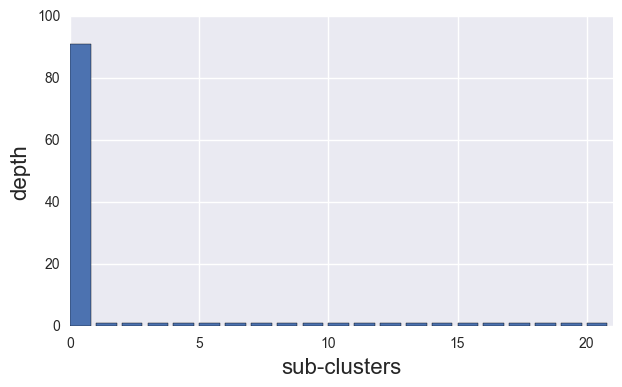

In [356]:
display_cluster_word(proto_details, en_word)
len([len(s) for s in proto_details['subclusters'][en_word]])

In [311]:
proto_details = read_prototypes()

117608


In [312]:
en_stop_words = set(nltk.corpus.stopwords.words("english"))
proto_sorted_by_instances = [k for k, v in sorted(proto_details['instances'].items(), 
                                                  reverse=True, key=lambda t: len(t[1]))
                             if k.lower() not in en_stop_words]
# proto_details[es_word]
k_start = 75
k_end = k_start + 10
print("{0:>20s} | {1:>10s}".format("proto","# instances"))
print("\n".join("{0:>20s} | {1:>10d}".format(k, len(proto_details['instances'][k])) 
                for k in proto_sorted_by_instances[k_start: k_end]))
# en_stop_words

               proto | # instances
                SAYS |        118
                TALK |        118
               SINCE |        114
             HUNDRED |        111
               MONEY |        111
                 DAD |        111
                EVEN |        108
               HELLO |        106
             ANOTHER |        105
                 GOT |        105


In [313]:
en_word = 'MONEY'

In [314]:
proto_details['instances'][en_word][:5]

[Instance(uttr='041.081', start=237, end=280),
 Instance(uttr='071.073', start=62, end=87),
 Instance(uttr='110.081', start=433, end=459),
 Instance(uttr='050.144', start=364, end=405),
 Instance(uttr='063.150', start=590, end=614)]

In [315]:
def play_proto_instances(proto_details, en_word, num_i=5):
    print("playing {0:d} instances for prototype = {1:s}\n".format(num_i, en_word))
    for i in proto_details['instances'][en_word][:num_i]:
        uttr_string = "uttr = {0:s}, duration (ms) = {1:d}".format(i.uttr, (i.end-i.start)*10)
        print("{0:^50s}".format(uttr_string))
        _ = find_align_words_for_node(*i)
        print_align(i.uttr, "es")
        print_align(i.uttr, "en")
        play_uttr_seg(*i)

In [316]:
cost = sub_cluster_compute_dtw(proto_details, en_word)

it: 12210: 100%|██████████| 12321/12321 [00:20<00:00, 589.99it/s]


In [319]:
# proto_details['instances'][en_word]

In [361]:
play_proto_instances(proto_details, en_word, num_i=10)

playing 10 instances for prototype = MONEY

       uttr = 041.081, duration (ms) = 430        
   es alignment |           TANTA LANA, 530 ms
       es words | no no pues ya porque es tampoco es tanta lana mamá tiene que
       en words | no no because is it is so much money mom has to


       uttr = 071.073, duration (ms) = 250        
   es alignment |               DINERO, 390 ms
       es words |                         cuál otro dinero
       en words |                         what other money


       uttr = 110.081, duration (ms) = 260        
   es alignment |             CUENTITA, 790 ms
       es words | claro claro cuando yo les mande esto tú tienes mi cuentita de plata tú vas sacando de ahí has sacado lo de la
       en words | sure sure when i send them this you have my little money account you withdrawing have withdrawn withdrawn withdrawn from there for the


       uttr = 050.144, duration (ms) = 410        
   es alignment |               DINERO, 540 ms
       es words |     ni dicen nada y enda no tiene dinero
       en words | nor they say anything and enda has no money


       uttr = 063.150, duration (ms) = 240        
   es alignment |                   NO, 410 ms
       es words | se quedaron ya se quedaron callados ya edmundo tiene razón no no es la cosa así no quieren poner plata no quieren poner plata ya definitivamente
       en words | they had they had shut up then edmundo is right no 's not not like this don 't want put money don 't want put money absolutely


       uttr = 063.150, duration (ms) = 360        
   es alignment |      DEFINITIVAMENTE, 610 ms
       es words | se quedaron ya se quedaron callados ya edmundo tiene razón no no es la cosa así no quieren poner plata no quieren poner plata ya definitivamente
       en words | they had they had shut up then edmundo is right no 's not not like this don 't want put money don 't want put money absolutely


       uttr = 117.132, duration (ms) = 500        
   es alignment |     QUE JUNTAR PLATA, 880 ms
       es words | claro quiero ir pero tendría que tendría que juntar plata si ese es el problema
       en words | sure want go but 'd have to save money that 's the problem


       uttr = 090.001, duration (ms) = 380        
   es alignment |        LLEGA PLATA A, 530 ms
       es words | quedaría si no me llega plata a finales de octubre
       en words | if if don 't get money by end of october


       uttr = 089.015, duration (ms) = 290        
   es alignment |         DINERO A UNA, 360 ms
       es words | claro pregunten allá digan que necesitan mandar este dinero a una persona que tiene esta cuenta que de qué manera se le puede
       en words | sure ask there tell that need send this money to someone who has this account see if if they they can


       uttr = 060.150, duration (ms) = 440        
   es alignment |  QUE LLEGó EL DINERO, 840 ms
       es words | que llegó el dinero que le prestó papá papá le prestó un dinero acá
       en words | the money that dad loaned to him got here dad loaned him some money


In [362]:
proto_details['subclusters'] = {}

In [363]:
sub_cluster_word(proto_details, en_word, cost, sim_thresh=.2)

prototype		| MONEY
# of instances		| 111
# of sub-clusters	| 39
playing subcluster 0, total instances = 1


playing subcluster 1, total instances = 68


playing subcluster 2, total instances = 1


playing subcluster 3, total instances = 1


playing subcluster 4, total instances = 4


playing subcluster 5, total instances = 1


playing subcluster 6, total instances = 1


playing subcluster 7, total instances = 1


playing subcluster 8, total instances = 1


playing subcluster 9, total instances = 2


playing subcluster 10, total instances = 2


playing subcluster 11, total instances = 1


playing subcluster 12, total instances = 1


playing subcluster 13, total instances = 1


playing subcluster 14, total instances = 1


playing subcluster 15, total instances = 1


playing subcluster 16, total instances = 1


playing subcluster 17, total instances = 1


playing subcluster 18, total instances = 1


playing subcluster 19, total instances = 1


playing subcluster 20, total instances = 1


playing subcluster 21, total instances = 1


playing subcluster 22, total instances = 1


playing subcluster 23, total instances = 1


playing subcluster 24, total instances = 1


playing subcluster 25, total instances = 1


playing subcluster 26, total instances = 1


playing subcluster 27, total instances = 1


playing subcluster 28, total instances = 1


playing subcluster 29, total instances = 1


playing subcluster 30, total instances = 1


playing subcluster 31, total instances = 1


playing subcluster 32, total instances = 1


playing subcluster 33, total instances = 1


playing subcluster 34, total instances = 1


playing subcluster 35, total instances = 1


playing subcluster 36, total instances = 1


playing subcluster 37, total instances = 1


playing subcluster 38, total instances = 1


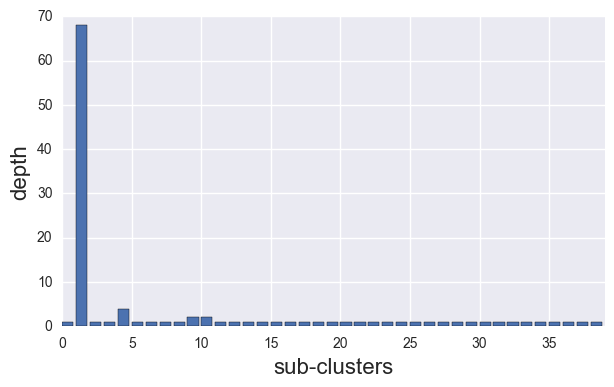

In [359]:
display_cluster_word(proto_details, en_word)

In [360]:
print([len(s) for s in proto_details['subclusters'][en_word]])

[1, 68, 1, 1, 4, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


(array([  111.,    16.,   282.,  2128.,  4500.,  3390.,  1320.,   442.,
          106.,    26.]),
 array([ 0.   ,  0.068,  0.135,  0.203,  0.27 ,  0.338,  0.405,  0.473,
         0.54 ,  0.608,  0.675]),
 <a list of 10 Patch objects>)

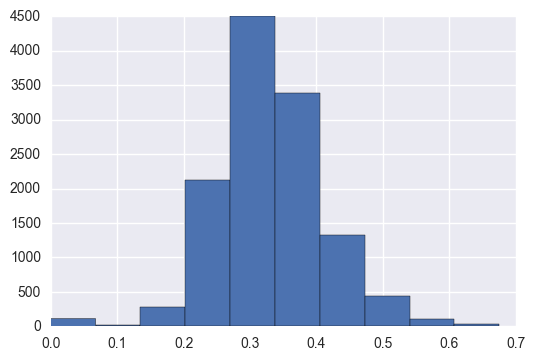

In [329]:
plt.hist(cost.ravel())